## Introduction
The Goal of this project is to develop a model capable of classifying mixed patterns of proteins in  microscope images. However, unlike most image labeling tasks, where binary or multiclass labeling is considered, in this competition each image can have multiple labels.  Here all image samples are represented by four filters (stored as individual files), **the protein of the protein of    interest (green) interest (green) ​​plus three cellular landmarks: ​nucleus (blue) nucleus (blue)​​, ​microtubules (red) microtubules (red)​​,​ endoplasmic endoplasmic    reticulum (yellow reticulum (yellow​​).** Therefore, An additional challenge is 4-channel input to the model (RGBY),  which is different from ones used in most of pretrained models (RGB input).   ​Images we will be using for this are generated with the help of microscope and at a far greater pace  than what can be manually evaluated. Therefore, the need is greater than ever for automating  biomedical image analysis to accelerate the understanding of human cells and disease. 

In [1]:
#installing fastai and torchvision 
!pip install fastai==0.7.0 --no-deps
!pip install torch==0.4.1 torchvision==0.2.1

    100% |████████████████████████████████| 122kB 3.6MB/s ta 0:00:01
  Found existing installation: fastai 1.0.39
    Uninstalling fastai-1.0.39:
      Successfully uninstalled fastai-1.0.39
You are using pip version 18.1, however version 19.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
    100% |████████████████████████████████| 519.5MB 80kB/s  eta 0:00:01  6% |██                              | 32.4MB 35.4MB/s eta 0:00:14    9% |███                             | 47.8MB 31.7MB/s eta 0:00:15    11% |███▌                            | 57.4MB 34.9MB/s eta 0:00:14    14% |████▋                           | 74.7MB 37.0MB/s eta 0:00:13    18% |█████▉                          | 94.1MB 36.3MB/s eta 0:00:12    19% |██████▍                         | 103.8MB 35.5MB/s eta 0:00:12    22% |███████                         | 115.4MB 36.5MB/s eta 0:00:12    25% |████████                        | 130.9MB 35.4MB/s eta 0:00:11    26% |████████▍                 

## Problem Statement 
Classification of proteins has been limited to single patterns in one or a few cell types, but in order  to fully understand the complexity of the human cell, models must classify mixed patterns across a  range of different human cells. And automating the biomedical image analysis will  accelerate the  understanding of human cells and disease. 

In [2]:
# import necessary libs
from fastai.conv_learner import *
from fastai.dataset import *

import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import scipy.optimize as opt
import matplotlib.pyplot as plt

In [3]:
#load train.csv
data = pd.read_csv('../input/train.csv')
print(data.shape)
data.head()

(31072, 2)


,Id,Target
0,00070df0-bbc3-11e8-b2bc-ac1f6b6435d0,16 0
1,000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0,7 1 2 0
2,000a9596-bbc4-11e8-b2bc-ac1f6b6435d0,5
3,000c99ba-bba4-11e8-b2b9-ac1f6b6435d0,1
4,001838f8-bbca-11e8-b2bc-ac1f6b6435d0,18


In [4]:
# total label names 
label_names = {
    0:  "Nucleoplasm",  
    1:  "Nuclear membrane",   
    2:  "Nucleoli",   
    3:  "Nucleoli fibrillar center",   
    4:  "Nuclear speckles",
    5:  "Nuclear bodies",   
    6:  "Endoplasmic reticulum",   
    7:  "Golgi apparatus",   
    8:  "Peroxisomes",   
    9:  "Endosomes",   
    10:  "Lysosomes",   
    11:  "Intermediate filaments",   
    12:  "Actin filaments",   
    13:  "Focal adhesion sites",   
    14:  "Microtubules",   
    15:  "Microtubule ends",   
    16:  "Cytokinetic bridge",   
    17:  "Mitotic spindle",   
    18:  "Microtubule organizing center",   
    19:  "Centrosome",   
    20:  "Lipid droplets",   
    21:  "Plasma membrane",   
    22:  "Cell junctions",   
    23:  "Mitochondria",   
    24:  "Aggresome",   
    25:  "Cytosol",   
    26:  "Cytoplasmic bodies",   
    27:  "Rods & rings"
}

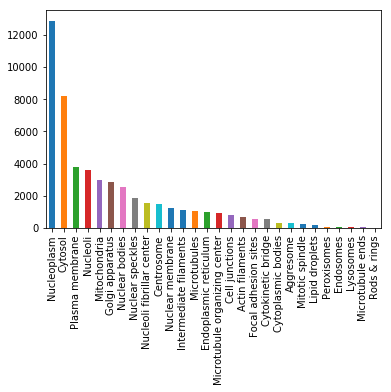

In [5]:
#class counts
one_hot = data.Target.str.get_dummies(sep=' ')
one_hot.columns = map(int, one_hot.columns); one_hot.head()
counts = one_hot.agg('sum')[:].rename(lambda x: label_names[x]).sort_values(ascending=False)
counts.plot('bar')

## Data Exploration
Let's take a look at some of the images and try to imagine what we want our net to find here.

In [6]:
DIR = '../input/train'
print(len([name for name in os.listdir(DIR) if os.path.isfile(os.path.join(DIR, name))]))

124288


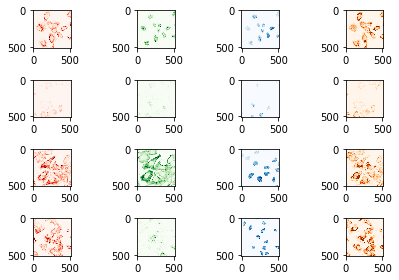

In [7]:
import matplotlib.image as mpimg
def plot_images_row(img_id, ax_row):
    filters = ['red', 'green', 'blue', 'yellow']
    colormaps = ['Reds', 'Greens', 'Blues', 'Oranges']
    
    for c, ax, cmap in zip(filters, ax_row, colormaps):
        filename = img_id + '_' + c + '.png'
        img=mpimg.imread(os.path.join(DIR, filename))
        imgplot = ax.imshow(img, cmap=cmap)


id_list = data.sample(4).Id.tolist()
fig, axes = plt.subplots(nrows=4, ncols=4)

for img_id, ax_row in zip(id_list, axes):
    plot_images_row(img_id, ax_row)
 
plt.tight_layout()

## Data Prepration 

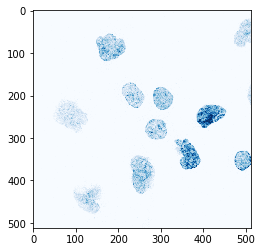

In [8]:
# lets see the image with a single colour channel (Blue)
color = 'blue'
filename = id_list[0] + '_' + color + '.png'
img=mpimg.imread(os.path.join(DIR, filename))
plt.imshow(img, cmap="Blues")

In [9]:
#seprating our training and validation data
label_csv = '../input/train.csv'
n = len(list(open(label_csv)))-1 # no. of samples in train.csv
val_idxs = get_cv_idxs(n) # returns the list of randomly choosen indexs that we will bw using for validation

In [10]:
import pathlib
    
def get_data(sz, colour): #size: pass the required size (256)  ,colour: choose any color in [red, green, blue, yellow]
    
         #a function that gives us the training and 
          #   validation data based on colour channel
               
    tfms = tfms_from_model(f_model, sz, aug_tfms=transforms_top_down, max_zoom=1.1)       
    data = ImageClassifierData.from_csv('../input', 'train', label_csv,bs=32, tfms=tfms,
                    suffix='_{}.png'.format(colour), val_idxs=val_idxs, test_name='test') 
    data.path = pathlib.Path('.')
    return data

## Building The Model

* I have tried to build my model with the combination of all 4 channels (Red, Green, Blue, and Yellow), but did not get the good results. So, I decided to build my model only with the green color channel as mentioned in the competition description.

In [11]:
#define the model and get the data
f_model = resnet34             #model
data = get_data(256, 'green')  #load the data by passing the desird colour channel

In [12]:
# evluation metrics: F1 score 'macro'
def f1(preds, targs, start=0.17, end=0.24, step=0.01):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        return max([f1_score(targs, (preds>th), average='macro')
                    for th in np.arange(start,end,step)])

metrics=[f1]

In [13]:
learn = ConvLearner.pretrained(f_model, data, ps=0.5, metrics=metrics) # creating the learner

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /tmp/.torch/models/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:04<00:00, 21513112.71it/s]
/opt/conda/lib/python3.6/site-packages/fastai/initializers.py:6: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  if hasattr(m, 'weight'): init_fn(m.weight)
/opt/conda/lib/python3.6/site-packages/fastai/initializers.py:6: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  if hasattr(m, 'weight'): init_fn(m.weight)


## Hyperparameters

In [14]:
#to find a suitable learning rate
lrf=learn.lr_find() # function from fastai lib


epoch      trn_loss   val_loss   f1                          
    0      0.205639   0.247377   0.08102   


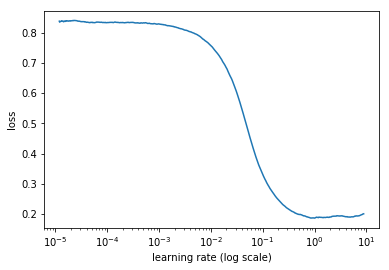

In [15]:
learn.sched.plot()  # function from fastai lib

## Training 


In [16]:
#unfreez the weights of the pretrained model
lr = 0.05
learn.unfreeze()
lrs=np.array([lr/10,lr/3,lr])

In [ ]:
learn.fit(lrs/4, 5, cycle_len=1, cycle_mult=2)


  0%|          | 0/777 [00:00<?, ?it/s]

In [ ]:
#F1 score 'macro' on validation data
multi_preds, y = learn.TTA()       #using test time Augmentation 
preds = np.mean(multi_preds, 0)
f1(preds,y) # gives the f1 score 'macro'

Here we have F1 score of **0.37**  and it will be improved for testing data,  because our trainng data has some rare cases with only one sample, So there are few cases where some validation samples appears in validation set t not in he trainng set. We can use Oversmapling but did not use oversmapling but I found that did not give much improvment in F1 score for test data, So Instead I use the whole data with auhmnetation for trainng and left no data for validation while traing my final model to make prediction for test data and got into top 29% of the leaderbord on kaggle.

## Submission

In [ ]:
#making predictions for the testing data
preds_t,y_t = learn.TTA(n_aug=8,is_test=True)
preds_t = np.stack(preds_t, axis=-1)
pred_t = preds_t.mean(axis=-1)

In [ ]:
def save_pred(pred, th=0.0, fname='Submission.csv'):
    pred_list = []
    for line in pred:
        s = ' '.join(list([str(i) for i in np.nonzero(line>th)[0]]))
        pred_list.append(s)
    
    df = pd.DataFrame({'Id':learn.data.test_ds.fnames,'Predicted':pred_list})
    df.sort_values(by='Id').to_csv(fname, header=True, index=False)

In [ ]:
save_pred(pred_t,0.01,'Submission.csv')
FileLink('Submission.csv')

In [ ]:
pd.read_csv('Submission.csv').head()

**Note** : I did this project in kaggle kernel. 

Reference [https://github.com/GdMacmillan/kaggle-protein-classification/blob/master/notebook/EDA%20and%20baseline.ipynb](https://github.com/GdMacmillan/kaggle-protein-classification/blob/master/notebook/EDA%20and%20baseline.ipynb)